In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
%matplotlib inline

c:\programdata\miniconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\programdata\miniconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\programdata\miniconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [7]:
data_path = os.path.join(str(os.getcwd()), '..', 'data')
df = pd.read_csv(os.path.join(data_path, "training_set.csv.zip"))
df_meta = pd.read_csv(os.path.join(data_path, "training_set_metadata.csv"))

In [8]:
df_meta.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


Text(0.5, 1.0, 'Number of timeseries per class')

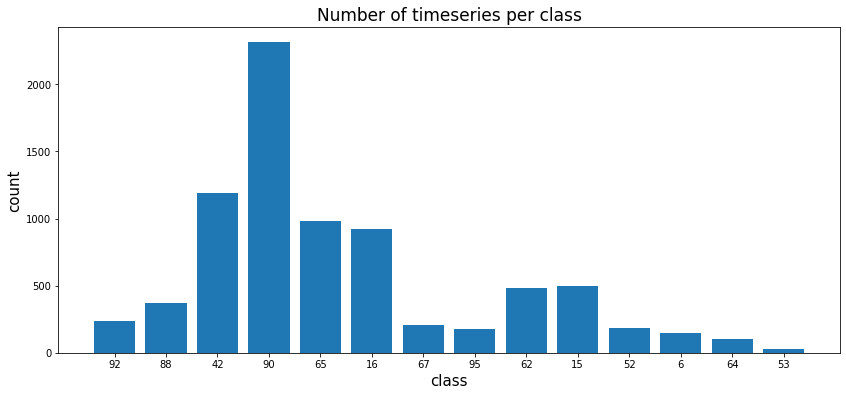

In [9]:
class_count = defaultdict(int)
for l in df_meta["target"]:
    class_count[l] += 1
    
labels_cc, values_cc = zip(*class_count.items())
indexes = np.arange(len(labels_cc))

fig = plt.figure(figsize=(14, 6))
plt.bar(indexes, values_cc)
plt.xticks(indexes, labels_cc)
plt.xlabel("class", fontsize=15)
plt.ylabel("count", fontsize=15)
plt.title("Number of timeseries per class", fontsize=17)

## first reduction: number of classes

as a first preprocessing step, we will discard every class with less than a fixed number of time series in order to make a more simplest dataset for testing reducing the number of classes with small amount of train and test data

In [10]:
threshold = 400
df_meta = df_meta.sort_values(by=["target"])
df_meta_filtered = df_meta[df_meta['target'].map(df_meta['target'].value_counts()) >= threshold]
classes = np.unique(df_meta_filtered["target"])
print("surviving classes are:", classes)
df_meta_filtered.shape[0]

surviving classes are: [15 16 42 62 65 90]


6390

we take time series fro the passband '3'

In [11]:
passband_id = 3

df = df[df["passband"] == passband_id]
df = df.sort_values(by=["object_id", "mjd"])
df_grouped = df.groupby("object_id")
fluxes = df_grouped["flux"].apply(list)
mjds = df_grouped["mjd"].apply(list)
labels = []
dataset = []
times = []
for i in range(df_meta_filtered.shape[0]):
    row = df_meta_filtered.iloc[i]
    object_id = row.object_id
    target = row.target
    labels.append(target)
    dataset.append(np.array(fluxes.loc[object_id]))
    times.append(np.array(mjds.loc[object_id]))

### Second reduction: train/test data size

since at first we will use non-optimize solutions which will take lot of time to execute, we will start evaluating our experimentes on small sub-sets from the original dataset. From here, we will test three scenarios:

1. constant train/test set ratio but increasing the number of timeseries
2. constant test set size but increasing the size of train set
3. constant train set size but increasing the size of the test set

in particular here, for the 3rd scenario we will just have to fix the train set size and get a test size as big as posible, then on evaluation process we will take only sub-sets of this test set

for the 2nd scenario, we will fix the test set size on 1/3 of the maximum train set size

In [12]:
def get_small_dataset(dataset, times, labels, n1, n2):
    # n: size of the small dataset
    # c: use the 'c' classes most present in the original dataset
    
    data_time_tuple = [(t, y) for t, y in zip(times, dataset)]
    
    # first split, to get n1+n2 set size
    if n1+n2 < len(labels) - np.unique(labels).size:
    
         _, data_time_tuple, _,  labels = train_test_split(data_time_tuple, labels,
                                                    test_size=n1 + n2,
                                                    random_state=0,
                                                    stratify=labels)
        
    # second split, to get train n1 and test n2
    data_time_train, data_time_test, labels_train, labels_test = train_test_split(data_time_tuple,
                                                                                 labels,
                                                                                 test_size=n2,
                                                                                 random_state=0,
                                                                                 stratify=labels)
    d_train = []
    d_test = []
    t_train = []
    t_test = []
    for i in range(n1):
        t, d = data_time_train[i]
        d_train.append(d)
        t_train.append(t)
        
    for i in range(n2):
        t, d = data_time_test[i]
        d_test.append(d)
        t_test.append(t)

    
    return d_train, t_train, labels_train, d_test, t_test, labels_test


def gen_sub_sets(output_path, dataset, times, labels, n1_arr, n2_arr, c):
    for n1, n2 in zip(n1_arr, n2_arr):
        d_train, t_train, l_train, d_test, t_test, l_test = get_small_dataset(dataset, times, labels,
                                                                             n1, n2)
        skip = False
        for type_i, data_i in zip(["d", "t", "l"],
                                  [(d_train, d_test), (t_train, t_test), (l_train, l_test)]):
            out_file_train = os.path.join(output_path, "train_{}_n{}_c{}.npy".format(type_i, n1, c))
            out_file_test = os.path.join(output_path, "test_{}_n{}_c{}.npy".format(type_i, n2, c))
            if not os.path.exists(out_file_train):
                np.save(out_file_train, data_i[0])
                np.save(out_file_test, data_i[1])
            else:
                skip = True
                break
        if not skip:
            print(":::GEN [train, test, classes] = [%d, %d, %d] set on dir %s" % (n1, n2, c, output_path))
        else:
            print(":::SKIP [train, test, classes] = [%d, %d, %d]" % (n1, n2, c))

In [15]:
# 1st scenario
ratio = 2/8 # 20% test, 80% train
n1_arr = np.array([100, 500, 1000, 2000, 4000, 5000], dtype=int)
n2_arr = (n1_arr * ratio).astype(int)
output_path1 = os.path.join(data_path, "plasticc_subsets", "scenario1_ratio_2-8")
gen_sub_sets(output_path1, dataset, times, labels, n1_arr, n2_arr, len(classes))

:::GEN [train, test, classes] = [100, 25, 6] set on dir D:\tesis\tesis\notebooks\..\data\plasticc_subsets\scenario1_ratio_2-8
:::GEN [train, test, classes] = [500, 125, 6] set on dir D:\tesis\tesis\notebooks\..\data\plasticc_subsets\scenario1_ratio_2-8
:::GEN [train, test, classes] = [1000, 250, 6] set on dir D:\tesis\tesis\notebooks\..\data\plasticc_subsets\scenario1_ratio_2-8
:::GEN [train, test, classes] = [2000, 500, 6] set on dir D:\tesis\tesis\notebooks\..\data\plasticc_subsets\scenario1_ratio_2-8
:::GEN [train, test, classes] = [4000, 1000, 6] set on dir D:\tesis\tesis\notebooks\..\data\plasticc_subsets\scenario1_ratio_2-8
:::GEN [train, test, classes] = [5000, 1250, 6] set on dir D:\tesis\tesis\notebooks\..\data\plasticc_subsets\scenario1_ratio_2-8


In [15]:
#2nd scenario

In [16]:
#3rd scenario